# Pruebas nuevo ForecasterAutoregMultiseries (0.12.0)

Funcionalidades a probar:

+ Series es dataframe y exog es dataframe

+ Series es dataframe y exog es diccionario con distintas exógenas para cada serie

+ Series es diccionario y exog es diccionario

+ Series es diccionario con series de diferente longitud:
    + Se almacena correctamente last_window
    + ¿Que series se permiten predecir?
    + ¿Que series se permiten predecir si se le pasa un last_window?

+ Series es diccionario y exog es diccionario con algunas exógenas con valores ausentes

+ Comparar impacto de diferentes encodings en terminos de predicción y tiempos de ejecución

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

# Data management
# ==============================================================================
import numpy as np
import pandas as pd
from datetime import datetime

# Graphics
# ==============================================================================
import matplotlib.pyplot as plt

# Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

c:\anaconda\envs\skforecast_11_py12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load preprocessed data
# ==============================================================================
url = "https://drive.google.com/file/d/1fMsYjfhrFLmeFjKG3jenXjDa5s984ThC/view?usp=sharing"
file_id = url.split('/')[-2]
url = 'https://drive.google.com/uc?id=' + file_id
data = pd.read_parquet(url)
print("Data shape:", data.shape)


# Fill missing values of air_temperature and wind_speed using fowrard and backward fill
# ==============================================================================
# Imputation must be done separately for each building
data = data.sort_values(by=['building_id', 'timestamp'])
data['air_temperature'] = data.groupby('building_id')['air_temperature'].ffill().bfill()
data['wind_speed'] = data.groupby('building_id')['wind_speed'].ffill().bfill()
data = data.sort_index()

print(
    f"Rage of dates available : {data.index.min()} --- {data.index.max()}  "
    f"(n_days={(data.index.max() - data.index.min()).days})"
)

Data shape: (444324, 10)
Rage of dates available : 2016-01-01 00:00:00 --- 2016-12-31 00:00:00  (n_days=365)


In [3]:
# Split data in train, validation and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'
end_validation = '2016-09-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(
    f"Rage of dates available : {data.index.min()} --- {data.index.max()} "
    f"(n_days={(data.index.max() - data.index.min()).days})"
)
print(
    f"  Dates for training    : {data_train.index.min()} --- {data_train.index.max()} "
    f"(n_days={(data_train.index.max() - data_train.index.min()).days})"
)
print(
    f"  Dates for validation  : {data_val.index.min()} --- {data_val.index.max()} "
    f"(n_days={(data_val.index.max() - data_val.index.min()).days})"
)
print(
    f"  Dates for test        : {data_test.index.min()} --- {data_test.index.max()} "
    f"(n_days={(data_test.index.max() - data_test.index.min()).days})"
)

Rage of dates available : 2016-01-01 00:00:00 --- 2016-12-31 00:00:00 (n_days=365)
  Dates for training    : 2016-01-01 00:00:00 --- 2016-07-31 00:00:00 (n_days=212)
  Dates for validation  : 2016-08-01 00:00:00 --- 2016-09-30 00:00:00 (n_days=60)
  Dates for test        : 2016-10-01 00:00:00 --- 2016-12-31 00:00:00 (n_days=91)


In [4]:
# Function to add calendar features to a DataFrame
# ==============================================================================
def day_of_week_cyclical_encoding(data):
    """
    Calculate cyclical encoding for the day of week using a 
    DataFrame with a datetime index.
    """
    data['day_of_week'] = data.index.dayofweek
    data['sin_day_of_week'] = np.sin(2*np.pi*data['day_of_week']/7)
    data['cos_day_of_week'] = np.cos(2*np.pi*data['day_of_week']/7)
    
    return data

# Exogenous Variables
# ==============================================================================
exog_features = ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']

# Reshape data to have one column per building
# ==============================================================================
data_pivot = data.pivot_table(
                 index    = 'timestamp',
                 columns  = 'building_id',
                 values   = 'meter_reading',
                 aggfunc  = 'mean' 
             )
data_pivot.columns = data_pivot.columns.astype(str)
data_pivot = data_pivot.asfreq('D').sort_index()

# Add calendar features
data_pivot = day_of_week_cyclical_encoding(data_pivot)

# Add temperature and wind speed as exogenous variables
data_pivot = data_pivot.merge(
                 data[['air_temperature', 'wind_speed']].resample('D').mean(),
                 left_index  = True,
                 right_index = True,
                 how         = 'left',
                 validate    = '1:m'
             )

data_pivot.head(3)

# Seleccción de 5 edificions y de todas las exógenas
# ==============================================================================
selected_buildings = ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']
sample = data_pivot[selected_buildings].copy()
sample_train = sample.loc[: end_train, :].copy()
sample_val   = sample.loc[end_train:end_validation, :].copy()
sample_test  = sample.loc[end_validation:, :].copy()
exog = data_pivot[exog_features].copy()
exog_train = exog.loc[: end_train, :].copy()
exog_val   = exog.loc[end_train:end_validation, :].copy()
exog_test  = exog.loc[end_validation:, :].copy()
display(sample)
display(exog)

,id_1000,id_1001,id_1002,id_1003,id_1004
timestamp,,,,,
2016-01-01,1012.500694,142.999700,3114.500198,2294.750893,7188.003021
2016-01-02,1158.500099,141.000801,4110.000000,1750.000198,8494.001007
2016-01-03,983.000099,137.000300,2965.000000,1455.750492,7130.001007
2016-01-04,1675.750496,133.000100,1269.500000,2141.000198,9955.000000
2016-01-05,1586.250694,127.000300,3360.500000,2384.870697,10519.001007
...,...,...,...,...,...
2016-12-27,1372.250000,127.000000,3488.000000,2058.000000,8460.000000
2016-12-28,1320.500000,110.000000,3267.000000,1999.250000,8322.000000
2016-12-29,1306.250000,103.000000,3768.000000,1942.250000,8594.000000


,sin_day_of_week,cos_day_of_week,air_temperature,wind_speed
timestamp,,,,
2016-01-01,-0.433884,-0.900969,6.416639,4.040115
2016-01-02,-0.974928,-0.222521,6.366474,4.530395
2016-01-03,-0.781831,0.623490,6.555272,3.273064
2016-01-04,0.000000,1.000000,6.704778,4.865404
2016-01-05,0.781831,0.623490,2.392998,5.228913
...,...,...,...,...
2016-12-27,0.781831,0.623490,8.068287,3.979160
2016-12-28,0.974928,-0.222521,10.153295,2.185585
2016-12-29,0.433884,-0.900969,8.112521,2.438633


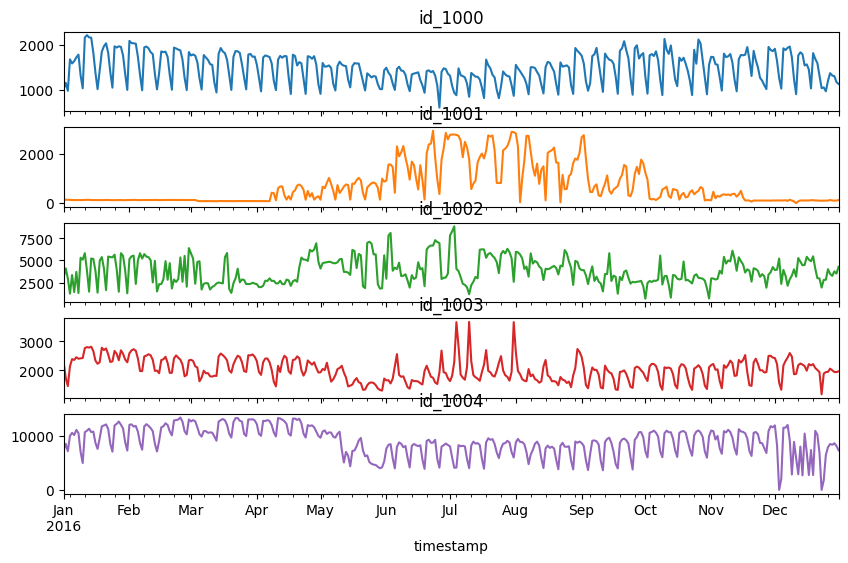

In [5]:
sample.plot(subplots=True, figsize=(10, 6) , legend=False, title=selected_buildings);

# Series is dataframe and exog is dataframe

In [6]:
# Series is dataframe and exog is dataframe
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot'
            )
forecaster.fit(series=sample_train, exog=exog_train)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
forecaster.predict(steps=5, exog=exog_val)

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['air_temperature', 'cos_day_of_week', 'sin_day_of_week', 'wind_speed'] 
Training range: {'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], 'id_1003': ['2016-01-01', '2016-07-31'], 'id_1004': ['2016-01-01', '2016-07-31']} 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance

,id_1000,id_1001,id_1002,id_1003,id_1004
2016-08-01,1327.934154,2763.367120,4915.963619,2865.523435,7640.932778
2016-08-02,1512.313254,2595.954790,5118.173757,2559.900923,8673.449418
2016-08-03,1405.337674,2212.581148,5017.600799,2146.961669,8544.457031
2016-08-04,1389.743284,1938.893262,4814.268348,2115.238965,9183.413650
2016-08-05,1333.151146,1666.679568,5623.632940,1998.986520,8865.803916


# Series is dataframe and exog is dictionary

In [7]:
# Series is dataframe and exog is dictionary
# ==============================================================================
exog_train_dict = {building: exog_train.copy() for building in sample_train.columns}
exog_val_dict   = {building: exog_val.copy() for building in sample_val.columns}
exog_test_dict  = {building: exog_test.copy() for building in sample_test.columns}

forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot'
            )
forecaster.fit(series=sample_train, exog=exog_train_dict)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
forecaster.predict(steps=5, exog=exog_val_dict)


ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['air_temperature', 'cos_day_of_week', 'sin_day_of_week', 'wind_speed'] 
Training range: {'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], 'id_1003': ['2016-01-01', '2016-07-31'], 'id_1004': ['2016-01-01', '2016-07-31']} 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learn

TypeError: `exog` must be a pandas Series or DataFrame.

# Series is dictionary and exog is dictionary

In [ ]:
sample_train.to_dict('series')

{'id_1000': timestamp
 2016-01-01    1012.500694
 2016-01-02    1158.500099
 2016-01-03     983.000099
 2016-01-04    1675.750496
 2016-01-05    1586.250694
                  ...     
 2016-07-27    1344.750595
 2016-07-28    1310.000397
 2016-07-29    1297.000893
 2016-07-30    1103.500397
 2016-07-31     871.500198
 Freq: D, Name: id_1000, Length: 213, dtype: float64,
 'id_1001': timestamp
 2016-01-01     142.999700
 2016-01-02     141.000801
 2016-01-03     137.000300
 2016-01-04     133.000100
 2016-01-05     127.000300
                  ...     
 2016-07-27    2224.000198
 2016-07-28    2334.000496
 2016-07-29    2559.000595
 2016-07-30    2911.000000
 2016-07-31    2903.000000
 Freq: D, Name: id_1001, Length: 213, dtype: float64,
 'id_1002': timestamp
 2016-01-01    3114.500198
 2016-01-02    4110.000000
 2016-01-03    2965.000000
 2016-01-04    1269.500000
 2016-01-05    3360.500000
                  ...     
 2016-07-27    5794.000000
 2016-07-28    6306.000000
 2016-07-29    5

In [ ]:
# Series is dictionary and exog is dictionary
# ==============================================================================
series_train_dict = sample_train.to_dict('series')
series_val_dict   = sample_val.to_dict('series')
series_test_dict  = sample_test.to_dict('series')
exog_train_dict = {building: exog_train.copy() for building in sample_train.columns}
exog_val_dict   = {building: exog_val.copy() for building in sample_val.columns}
exog_test_dict  = {building: exog_test.copy() for building in sample_test.columns}

forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 14,
                encoding  = 'onehot'
            )
forecaster.fit(series=series_train_dict, exog=exog_train_dict)

print(forecaster)
print("")
print("Last window information")
print("-----------------------")
for k, v in forecaster.last_window.items():
    print(f"{k}: length={len(v)}, index={v.index[0]}...{v.index[-1]}, freq={v.index.freq}")
print("")

print('Predictions')
print('------------')
forecaster.predict(steps=5, exog=exog_val_dict)


ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: onehot 
Window size: 14 
Series levels (names): ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['wind_speed', 'cos_day_of_week', 'sin_day_of_week', 'air_temperature'] 
Training range: {'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-01-01', '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-31'], 'id_1003': ['2016-01-01', '2016-07-31'], 'id_1004': ['2016-01-01', '2016-07-31']} 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learn

TypeError: `exog` must be a pandas Series or DataFrame.

# Puntos a revisar

+ ¿Exog en el predict tiene que ser necesariamente un dataframe? Ahora mismo hay conflicto de tipos. Predict espera un exog del mismo tipo que en train, pero tiene un check que en predict solo permite dataframe o serie. Si el forecaster se entrena con dict falla.